# Setup

In [1]:
!pip install tensorflow keras_cv luketils --upgrade --quiet
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflowjs 3.19.0 requires protobuf==3.20.0, but you have protobuf 3.19.4 which is incompatible.
reef-net 0.0.0 requires keras-cv==0.2.6, but you have keras-cv 0.3.4 which is incompatible.
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


# Basic Generations

In [2]:
import keras_cv
from tensorflow import keras
from luketils import visualization
import tensorflow as tf
from PIL import Image

In [3]:
keras.mixed_precision.set_global_policy("mixed_float16")
model = keras_cv.models.StableDiffusion(img_width=512, img_height=512, jit_compile=True)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA A100-SXM4-40GB, compute capability 8.0
By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


In [4]:
images = model.text_to_image("", batch_size=3)

25/25 [==============================] - 41s 159ms/step


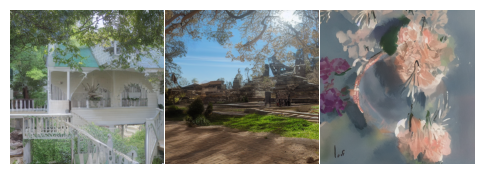

In [5]:
visualization.plot_gallery(images, value_range=(0, 255), rows=1, cols=3)

# Latent Walk

In [6]:
prompt_1 = "Mysterious ruins in the snow, concept art, digital, artstation"
prompt_2 = "Mysterious ruins in the summer sunlight, concept art, digital, artstation"
interpolation_steps = 50
filename = "ruins_1.gif"

In [7]:
def export_as_gif(filename, images, frames_per_second=13, rubber_band=False):
    if rubber_band:
        images += images[2:-1][::-1]
    images[0].save(
        filename,
        save_all=True,
        append_images=images[1:],
        duration=1000 // frames_per_second,
        loop=0,
    )

In [ ]:
encoding_1 = tf.squeeze(model.encode_text(prompt_1))
encoding_2 = tf.squeeze(model.encode_text(prompt_2))

batch_size = 10 # This value might to be lowered to 3 on a smaller GPU.
batches = interpolation_steps // batch_size

interpolated_encodings = tf.linspace(encoding_1, encoding_2, interpolation_steps)
batched_encodings = tf.split(interpolated_encodings, batches)

seed = 1337
noise = tf.random.normal((512 // 8, 512 // 8, 4), seed=seed)

images = []
for batch in range(batches):
    images += [
        Image.fromarray(img)
        for img in model.generate_image(
            batched_encodings[batch],
            batch_size=batch_size,
            num_steps=25,
            diffusion_noise=noise,
        )
    ]

export_as_gif(filename, images, rubber_band=True)

14/25 [===============>..............] - ETA: 3s

![](ruins_1.gif)